In [66]:
import json 
import numpy as np
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt

model = 'gpt2'
filter = 'filtered'
split = 'dev'
dataset = 'winobias'

# Plot y_{set-gender,z_set-gender}(u) - y_{set-gender,z_null(u)}(u) by
#  	 y_{null,z_set-gender(u)}(u) -  y_{null,z_null} (u)

fname = f"{dataset}_data/attention_intervention_{model}_{filter}_{split}.json"
with open(fname) as f:
	data = json.load(f)
x = []
y = []
for result in data['results']:
	y_null_z_set_gender = np.array(result['indirect_odds_head'])
	y_null_z_null = np.array(result['odds_base'])
	x.extend(( (y_null_z_set_gender - y_null_z_null) / y_null_z_null).flatten().tolist())
	y_set_gender_z_set_gender = np.array(result['odds_alt'])
	y_set_gender_z_null = np.array(result['direct_odds_head'])
	y.extend(((y_set_gender_z_set_gender - y_set_gender_z_null)/y_null_z_null).flatten().tolist())
	
assert len(x) == len(y) == 144 * len(data['results'])
x = np.array(x)
y = np.array(y)
for i in range(len(x)):
	if x[i] > 0.5 or y[i] > 0.5:
		print("Outlier", x[i], y[i])
print()

Outlier 0.6028453911945199 1.0677371469663122



CUTOFF None
1.04140 -0.00010
0.7798174314556029
changing coefficient to 1
1.00000
0.7785719609399814


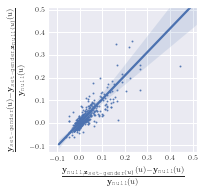

In [67]:
# data = np.array(zip(x, y))
cutoff = None
print('CUTOFF', cutoff)
if cutoff is not None:
	box = np.where((x < cutoff) & (x > -cutoff) & (y < cutoff) & (y > -cutoff))
	y_box = y[box]
	x_box = x[box]
else:
	y_box = y
	x_box = x
X = x_box.reshape(-1, 1)
Y = y_box.reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X, Y)
print(f"{reg.coef_[0].item():.5f}", f"{reg.intercept_.item():.5f}")#, {reg.intercept_:.5f}")
print(reg.score(X, Y))
reg.coef_[0] = 1
print("changing coefficient to 1")
print(f"{reg.coef_[0].item():.5f}")#, {reg.intercept_:.5f}")
print(reg.score(X, Y))

df = pd.DataFrame({'x': x_box, 'y': y_box})
# fig, ax = plt.subplots(figsize=(20,20))
# g = sns.lmplot(x='x', y='y', data=df, scatter_kws={"s": .2})

plt.rc('text', usetex=True)
plt.rcParams.update({
    "text.latex.preamble": [
         "\\usepackage{amsmath}",
		   "\\usepackage{amssymb}",
		 	"\\usepackage{times}",
			"\\usepackage{latexsym}",
			"\\usepackage{graphicx}",
			"\\usepackage{wrapfig}",
			"\\usepackage{booktabs}",
		 	"\\usepackage{array}",
		 	"\\usepackage{siunitx}",
			"\\usepackage{color,soul}",
			"\\usepackage{tikz}",
			"\\usetikzlibrary{bayesnet}",
		 	"\\usepackage{microtype}",
		 "\\usepackage{amsmath,amsfonts,bm}",#
#		 "\\DeclareMathSizes{18}{34}{14}{12}"
	 ]
})
# plt.rcParams.update({
#     "text.latex.preamble": [
# 		 	"\\documentclass[11pt,a4paper]{article}",
# 			"\\usepackage[hyperref]{acl2020}",
#          "\\usepackage{amsmath}",
# 		   "\\usepackage{amssymb}",
# 		 	"\\usepackage{times}",
# 			"\\usepackage{latexsym}",
# 			"\\usepackage{graphicx}",
# 			"\\usepackage{wrapfig}",
# 			"\\usepackage{booktabs}",
# 		 	"\\usepackage{array}",
# 		 	"\\usepackage{siunitx}",
# 			"\\usepackage{color,soul}",
# 			"\\usepackage{tikz}",
# 			"\\usetikzlibrary{bayesnet}",
# 		 	"\\usepackage{microtype}",
# 		 "\\usepackage{amsmath,amsfonts,bm}",#
# #		 "\\DeclareMathSizes{18}{34}{14}{12}"
# 	 ]
# })

# plt.rcParams['mathtext.default']='regular'
plt.figure(figsize=(3,2.9))
g = sns.regplot(x='x', y='y', data=df, scatter_kws={"s": 1})#,line_kws={'color':'green'})
# g = sns.lmplot(x='x', y='y', data=df, size=3, aspect=1, scatter_kws={"s": .5})

plt.axis('equal')
# if cutoff is not None:
# 	g.set(xlim=(-cutoff, cutoff))
# 	g.set(ylim=(-cutoff, cutoff))
# else:
# 	g.set_xlim([-.2, 1.2])
# 	g.set_xlim([-.2, 1.2])

# Exclude 1 outlier
# start, end = ax.get_xlim()
# 
# ax.xaxis.set_ticks(np.arange(start, end, 0.712123))
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
# g.set_xticks(g.get_yticks())
g.xaxis.set_ticks([-.1, 0, .1, .2, .3, .4, .5])
g.yaxis.set_ticks([-.1, 0, .1, .2, .3, .4, .5])
# g.set(xlabel=r'$\text{Hello}$')
g.set(xlabel=r'$\frac{\mathbf{y}_{\texttt{null},\mathbf{z}_{\texttt{set-gender}}(u)}(u) -  \mathbf{y}_{\texttt{null}}(u)}{\mathbf{y}_{\texttt{null}}(u)}$',
		ylabel=r'$\frac{\mathbf{y}_{\texttt{set-gender}}(u) -  \mathbf{y}_{\texttt{set-gender},\mathbf{z}_{\texttt{null}}(u)}(u)}{\mathbf{y}_{\texttt{null}}(u)}$')
g.tick_params(axis='x', pad=1, length=2)
g.tick_params(axis='y', pad=1, length=2)
g.xaxis.labelpad = 6
g.yaxis.labelpad = 2
plt.setp(g.get_yticklabels(), fontsize=7)
plt.setp(g.get_xticklabels(), fontsize=7)
# g.set_xlim([-.2, 0.5])
# g.set_xlim([-.2, 0.5])
g.set(xlim=(-0.12, 0.5), ylim=(-0.12, 0.5))

plt.tight_layout()
plt.savefig(f'results/attention_intervention/te_equation_plot.pdf', format='pdf')
            